In [1]:
import numpy as np
import os
import pickle
import torch
import open_clip

import open3d as o3d

from scipy.spatial import cKDTree
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from scipy.spatial.transform import Rotation as R

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
all_datasets_path = "/scratch/kumaraditya_gupta/Datasets/mp3d_train_3"
gt_dir = "/scratch/yash_mehan/mp3d_gt_instance_labelled"
dataset_name = "2t7WUuJeko7"
seq_name = "sequence1"
version = "output_objs_v1"

dataset_path = os.path.join(all_datasets_path, dataset_name, seq_name)
imgs_dir = os.path.join(dataset_path, "color")

def load_gt_data(gt_dir, dataset_name):
    gt_file_name = f"{dataset_name}_xyz_rgb_o_r_inst.npy"
    gt = np.load(os.path.join(gt_dir, gt_file_name)) # (N, 9)
    return gt

gt = load_gt_data(gt_dir, dataset_name)

output_dir = os.path.join(dataset_path, f"output_{version}")

obj_nodes_path = os.path.join(output_dir, "scene_obj_nodes.pkl")
with open(obj_nodes_path, 'rb') as file:
    obj_nodes_dict = pickle.load(file)

img_dict_path = os.path.join(output_dir, "img_dict.pkl")
with open(img_dict_path, 'rb') as file:
    img_dict = pickle.load(file)

In [3]:
# gt shape is (N, 9) and format [x, y, z, r, g, b, obj, room_label_id, instance_number]

ALL_ROOM_TYPES = ["bathroom", "bedroom", "closet", "dining", "entryway", 
"family", "garage", "hallway", "library", "laundry", 
"kitchen", "living", "meeting", "lounge", "office", 
"porch", "recreation", "stairs", "toilet", "utility", 
"tv", "gym", "outdoor", "balcony", "other", 
"bar", "classroom", "sauna", "junk", "none"]

for row in gt:
    room_label_id = int(row[7])
    instance_number = int(row[8])

    # update the rows with ints
    row[7] = room_label_id
    row[8] = instance_number


OUR_ROOM_DICT = {
    'bathroom': 0,
	'toilet': 0,
	'sauna': 0,
	'bedroom': 1,
	'closet': 2,
	'dining': 3,
	'entryway': 4,
	'family': 5,
	'tv': 5,
	'living': 5,
	'lounge': 5,
	'recreation': 5,
	'garage': 6,
	'hallway': 7,
	'library': 8,
	'laundry': 9,
	'utility': 9,
	'kitchen': 10,
    'meeting': 11,
	'office': 11,
	'porch': 12,
	'stairs': 13,
	'gym': 14,
	'outdoor': 15,
	'balcony': 16,
	'bar': 17,
	'other': 18,
	'classroom': 18,
	'junk': 18,
    'none': 18
}

OUR_ROOM_TYPES = [
    "bathroom",
    "bedroom",
    "closet",
    "dining",
    "entryway",
    "living",
    "garage",
    "hallway",
    "library",
    "laundry",
    "kitchen",
    "office",
    "porch",
    "stairs",
    "gym",
    "outdoor",
    "balcony",
    "bar",
    "other"        
]

In [4]:
# Maps from old room_label_id to new room_label_id
old_to_new_room_id = {ALL_ROOM_TYPES.index(room): OUR_ROOM_DICT[room] for room in OUR_ROOM_DICT}

# Dictionary to track the new instance number for each unique (new_room_id, old_instance) pair
unique_instance_mapping = {}

# New instance number for each new room ID
new_instance_counter = {i: 0 for i in range(0, len(OUR_ROOM_TYPES))}

for point in gt:
    old_room_id = int(point[7])
    old_instance = int(point[8])
    new_room_id = old_to_new_room_id.get(old_room_id, 18)  # Default to 'other' if not found
    
    # Unique key for the original room_id and instance combination
    unique_key = (new_room_id, old_room_id, old_instance)
    
    if unique_key not in unique_instance_mapping:
        unique_instance_mapping[unique_key] = new_instance_counter[new_room_id]
        new_instance_counter[new_room_id] += 1
    
    # Update the ground truth data with the new room_label_id and new instance number
    point[7] = new_room_id
    point[8] = unique_instance_mapping[unique_key]


In [13]:
# gt shape is (N, 9) and format [x, y, z, r, g, b, obj, room_label_id, instance_number]
unique_room_ids = np.unique(['{}_{}'.format(int(room_label), int(instance_num)) for room_label, instance_num in gt[:, [7, 8]]])

# Initialize a dictionary to store mask coordinates for each room
room_masks = {}

# Iterate over each unique room ID and plot
for room_id in unique_room_ids:
    room_label, instance_num = map(int, room_id.split('_'))
    
    # Filter points belonging to the current room
    room_points = gt[(gt[:, 7] == room_label) & (gt[:, 8] == instance_num)]
    x, y, z = room_points[:, 0], room_points[:, 1], room_points[:, 2]
    room_masks[room_id] = (x, y, z)

# Create a KD-tree for each room
kd_trees = {}
for room_id, (x, y, z) in room_masks.items():
    points = np.stack((x, y, z), axis=-1)
    kd_trees[room_id] = cKDTree(points)


# Room-wise Poses

In [6]:
# Find which room each camera pose belongs to
pose_dir = os.path.join(dataset_path, "pose")
pose_files = os.listdir(pose_dir)

def get_pose(img_name):
    pose_path = os.path.join(pose_dir, img_name + '.txt')

    # check if the pose file exists, if it doesn't, return None
    # [x, y, z, qx, qy, qz, qw]
    if not os.path.exists(pose_path):
        return None
    
    with open(pose_path, 'r') as f:
        pose = f.read().split()
        pose = np.array(pose).astype(np.float32)

        #change pose from [x, y, z, qw, qx, qy, qz] to [x, y, z, qx, qy, qz, qw]
        pose = np.concatenate((pose[:3], pose[4:], pose[3:4]))
    return pose

def pose_correction(pose):
    # Parse the pose
    pos = np.array(pose[:3], dtype=float).reshape((3, 1))
    quat = pose[3:]
    rot = R.from_quat(quat).as_matrix()

    # Apply rotation correction, to match the orientation z: backward, y: upward, and x: right
    rot_ro_cam = np.eye(3)
    rot_ro_cam[1, 1] = -1
    rot_ro_cam[2, 2] = -1
    # Additional rotation to get the points in the correct orientation
    new_rot = np.array([[1.0, 0, 0], [0, 0, -1.0], [0, 1.0, 0]])

    combined_rot = new_rot @ rot @ rot_ro_cam

    cam_height = 1.50
    pos[1] += cam_height

    # Create the pose matrix
    pose_matrix = np.eye(4)
    pose_matrix[:3, :3] = combined_rot
    pose_matrix[:3, 3] = pos.reshape(-1)

    # create an array of point [0, 0, 0, 1] for camera_coord_homogenous
    camera_coord_homogenous = np.zeros((4, 1))
    camera_coord_homogenous[-1] = 1

    corrected_cam_xyz = new_rot @ pos
    corrected_cam_xyz = corrected_cam_xyz.reshape(-1)
    corrected_cam_quat = R.from_matrix(combined_rot).as_quat()

    return corrected_cam_xyz, corrected_cam_quat
    

In [14]:
# Assuming dataset_path is defined and room_masks is already populated
# Initialize a dictionary to store the room ID for each pose
pose_room_mapping = {}

# Iterate over each pose file
for img_id in tqdm(img_dict.keys()):
    pose = get_pose(img_id)
    pose_xyz, pose_quat = pose_correction(pose)

    min_distance = float('inf')
    room_id_for_pose = None

    for room_id, kd_tree in kd_trees.items():
        distance, _ = kd_tree.query(pose_xyz[:3])
        if distance < min_distance:
            min_distance = distance
            room_id_for_pose = room_id

    pose_room_mapping[img_id] = room_id_for_pose

print(f'Number of pose-room mappings: {len(pose_room_mapping)}')


  0%|          | 0/77 [00:00<?, ?it/s]

Number of pose-room mappings: 77


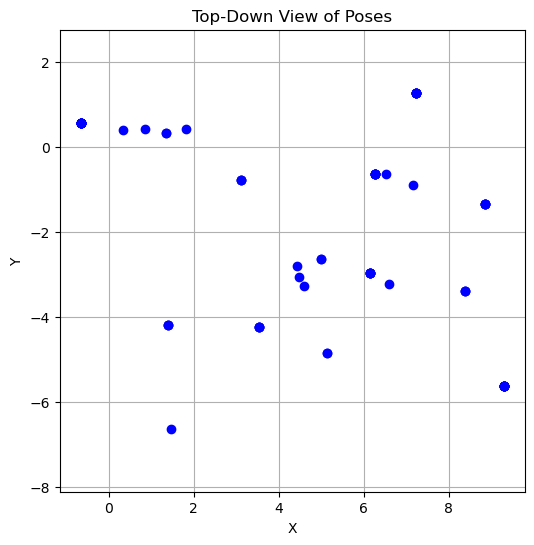

In [15]:
plt.figure(figsize=(6, 6))

for img_id in img_dict.keys():
    pose = get_pose(img_id)
    pose_xyz, pose_quat = pose_correction(pose)

    plt.scatter(pose_xyz[0], pose_xyz[1], color='blue')

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Top-Down View of Poses')
plt.grid(True)
plt.axis('equal')
plt.show()


/tmp/ipykernel_2040865/992732950.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('tab20', len(unique_room_ids))


  0%|          | 0/77 [00:00<?, ?it/s]

/home/kumaraditya_gupta/.conda/envs/instance-map/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


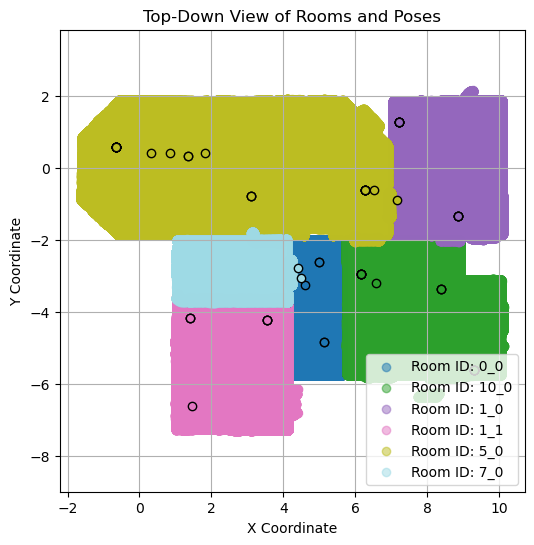

In [25]:
# Assuming you have `pose_room_mapping` and `room_masks` from the previous steps.

# Continue using the colormap defined for rooms
colormap = plt.cm.get_cmap('tab20', len(unique_room_ids))

# Create a new figure for plotting
plt.figure(figsize=(6, 6))

# Plot each room
for i, room_id in enumerate(unique_room_ids):
    room_id_single = room_id.split('_')[0]
    instance_number = room_id.split('_')[1]

    room_points = []
    for line in gt:
        if line[7] == int(room_id_single) and line[8] == int(instance_number):
            room_points.append(line[:3])

    room_points = np.array(room_points)

    x, y = room_points[:, 0], room_points[:, 1]
    plt.scatter(x, y, color=colormap(i), label=f'Room ID: {room_id}', alpha=0.5)  # Slightly transparent

# Plot each pose
for img_id, room_id in tqdm(pose_room_mapping.items()):
    pose_xyz = get_pose(img_id)
    pose_xyz, pose_quat = pose_correction(pose_xyz)
    
    # Find the color index from the unique_room_ids
    color_idx = np.where(unique_room_ids == room_id)[0][0]
    plt.scatter(pose_xyz[0], pose_xyz[1], color=colormap(color_idx), edgecolor='k')  # 'k' makes the edge color black for better visibility

# Enhance the plot
plt.legend()
plt.title('Top-Down View of Rooms and Poses')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.grid(True)
plt.axis('equal')  # Ensure equal scaling for x and y axes
plt.show()

# Optionally save the plot
# plt.savefig(f'{dataset_path}/rooms_and_poses.png')


# Room-wise Objects

In [10]:
# Initialize a dictionary to store the room assignment for each object
room_obj_assignments = {}

# Iterate through each object
for node_id, node_data in tqdm(obj_nodes_dict.items()):
    obj_bbox = node_data['bbox']  # 8x3 array of bbox points

    # Initialize a dictionary to keep the sum of minimum distances for each room
    room_distance_sum = {room_id: 0 for room_id in kd_trees.keys()}

    # Iterate through the 8 points of the bounding box
    for point in obj_bbox:
        # Initialize a dictionary to keep the minimum distance for each room for this point
        room_min_distance = {}

        # Check the distance of the point to each room
        for room_id, kd_tree in kd_trees.items():
            distance, _ = kd_tree.query(point[:3])  # Consider x, y, z for 3D KD-tree
            room_min_distance[room_id] = distance

        # Add the minimum distance to the room's total distance sum
        for room_id, distance in room_min_distance.items():
            room_distance_sum[room_id] += distance

    # Assign the object to the room with the minimum sum of distances
    assigned_room = min(room_distance_sum, key=room_distance_sum.get)
    
    if assigned_room not in room_obj_assignments:
        room_obj_assignments[assigned_room] = []
    room_obj_assignments[assigned_room].append(node_id)

    node_data['room_id'] = assigned_room

    room_label_id = assigned_room.split('_')[0]
    node_data['room_label'] = OUR_ROOM_TYPES[int(room_label_id)]

  0%|          | 0/101 [00:00<?, ?it/s]

In [12]:
room_obj_assignments_top30 = {}

for room_id, obj_ids in room_obj_assignments.items():
    if len(obj_ids) <= 30:
        room_obj_assignments_top30[room_id] = obj_ids
    else:
        obj_points_counts = []

        for obj_id in obj_ids:
            pcd_path = obj_nodes_dict[obj_id]['pcd']
            pcd = o3d.io.read_point_cloud(pcd_path)
            obj_points_counts.append((obj_id, len(pcd.points)))
        
        # Sort the list based on the number of points in descending order
        obj_points_counts.sort(key=lambda x: x[1], reverse=True)
        top_30_obj_ids = [obj_id for obj_id, _ in obj_points_counts[:30]]     
        room_obj_assignments_top30[room_id] = top_30_obj_ids


In [14]:
# save obj_node_dict.pkl
with open(obj_nodes_path, 'wb') as file:
    pickle.dump(obj_nodes_dict, file)

# save room_obj_assignments.pkl
with open(os.path.join(output_dir, "room_obj_assignments.pkl"), 'wb') as file:
    pickle.dump(room_obj_assignments_top30, file)

In [16]:
import random

def generate_pastel_color():
    # generate (r, g, b) tuple of random numbers between 0.5 and 1, truncate to 2 decimal places
    r = round(random.uniform(0.4, 1), 2)
    g = round(random.uniform(0.4, 1), 2)
    b = round(random.uniform(0.4, 1), 2)
    color = np.array([r, g, b])
    return color

# generate colors equal to the length of room_labels
room_id_to_color = {}
for room_id in room_obj_assignments_top30.keys():
    room_id_to_color[room_id] = generate_pastel_color()

In [19]:
save_path = os.path.join(output_dir, "pcds_roomwise")
if not os.path.exists(save_path):
    os.makedirs(save_path)

room_pcds = {}

# iterate over obj_nodes_dict and get the pcd for each node. Save the pcd with a color based on room label
for node_id, node_data in obj_nodes_dict.items():
    obj_pcd_path = node_data['pcd']
    obj_pcd = o3d.io.read_point_cloud(obj_pcd_path)
    obj_room_id = node_data['room_id']

    color = room_id_to_color[obj_room_id]
    obj_pcd.paint_uniform_color(color)
    o3d.io.write_point_cloud(os.path.join(save_path, f"{node_id}.pcd"), obj_pcd)

    if obj_room_id not in room_pcds:
        room_pcds[obj_room_id] = []
    room_pcds[obj_room_id].append(obj_pcd)

In [20]:
# now room_pcds contains the list of pcds for each room label
# we can merge them and save them in a separate folder
save_path = os.path.join(output_dir, "pcds_roomwise_merged")
if not os.path.exists(save_path):
    os.makedirs(save_path)

for room_id, pcd_list in room_pcds.items():
    merged_pcd = o3d.geometry.PointCloud()
    for pcd in pcd_list:
        merged_pcd += pcd
    o3d.io.write_point_cloud(os.path.join(save_path, f"{room_id}.pcd"), merged_pcd)

# Top-k images for each room

In [38]:
# img_objs_coverage : {room_id : {img_id : {node_id : points_contri_perc, ...}, ...}, ...}

roomwise_img_coverage = {}
for room_id, node_id_list in tqdm(room_obj_assignments.items()):

    img_coverage = {}

    for node_id in node_id_list:
        points_contri = obj_nodes_dict[node_id]['points_contri']
        points_contri_perc = points_contri / np.sum(points_contri)

        source_ids = obj_nodes_dict[node_id]['source_ids'] 

        for source_id, points_contri_perc in zip(source_ids, points_contri_perc):
            img_id, mask_id = source_id
            if img_id not in img_coverage:
                img_coverage[img_id] = {}
            img_coverage[img_id][node_id] = points_contri_perc

    roomwise_img_coverage[room_id] = img_coverage


  0%|          | 0/7 [00:00<?, ?it/s]

In [62]:
from collections import defaultdict

def calculate_similarity(img1, img2, img_coverage, largest_obj_ids):
    # Identify the primary contribution object for both images
    primary_obj_img1 = max(img_coverage[img1], key=img_coverage[img1].get) if img_coverage[img1] else None
    primary_obj_img2 = max(img_coverage[img2], key=img_coverage[img2].get) if img_coverage[img2] else None
    
    # Check if the primary contribution of both images is to the same largest object
    if (primary_obj_img1 in largest_obj_ids and primary_obj_img1 == primary_obj_img2):
        return 1  # Assign maximum similarity

    # If not, calculate Jaccard similarity of the objects covered
    objects_img1 = set(img_coverage[img1].keys())
    objects_img2 = set(img_coverage[img2].keys())
    intersection = len(objects_img1.intersection(objects_img2))
    union = len(objects_img1.union(objects_img2))
    return intersection / union if union != 0 else 0



def get_top_k_images(roomwise_img_coverage, room_obj_assignments, obj_nodes_dict, k, n, diversity_threshold=0.5):
    # Resultant dictionary
    roomwise_top_k_images = {}

    # Iterate through each room
    for room_id, img_coverage in roomwise_img_coverage.items():

        # Step 1: Find n biggest objects
        node_id_list = room_obj_assignments[room_id]
        node_pcd_paths = [obj_nodes_dict[node_id]['pcd'] for node_id in node_id_list]
        node_pcds = [o3d.io.read_point_cloud(pcd_path) for pcd_path in node_pcd_paths]
        node_pcd_sizes = np.array([len(np.asarray(pcd.points)) for pcd in node_pcds])
        
        # Get indices of n largest objects
        largest_obj_indices = node_pcd_sizes.argsort()[-n:][::-1]
        largest_obj_ids = [node_id_list[i] for i in largest_obj_indices]

        # Step 2: Rank images based on number of objects covered and total coverage percentage
        img_scores = defaultdict(lambda: {'obj_count': 0, 'coverage_perc': 0.0, 'covers_largest_objs': 0})
        
        for img_id, coverage in img_coverage.items():
            for node_id, points_contri_perc in coverage.items():
                img_scores[img_id]['obj_count'] += 1
                img_scores[img_id]['coverage_perc'] += points_contri_perc
                if node_id in largest_obj_ids:
                    img_scores[img_id]['covers_largest_objs'] += 1

        # Convert img_scores to a list and sort it based on criteria
        # Priority: covers_largest_objs, obj_count, coverage_perc
        sorted_imgs = sorted(img_scores.items(), key=lambda x: (
            x[1]['obj_count'], 
            x[1]['covers_largest_objs'],
            x[1]['coverage_perc']), reverse=True)

        # Step 3: Select top-k images with diversity filter
        top_k_images = []
        for img_info in sorted_imgs:
            img_id = img_info[0]
            
            # Calculate similarity and apply diversity filter
            if top_k_images:
                similarities = [calculate_similarity(img_id, selected_img, img_coverage, largest_obj_ids)
                                for selected_img in top_k_images]
                if max(similarities) > diversity_threshold:
                    continue  # Skip this image as it's too similar to already selected images
            
            top_k_images.append(img_id)
            if len(top_k_images) == k:
                break

        roomwise_top_k_images[room_id] = top_k_images

    return roomwise_top_k_images

# Usage
top_k_images_per_room = get_top_k_images(roomwise_img_coverage, room_obj_assignments, obj_nodes_dict, k=6, n=3, diversity_threshold=0.5)

In [63]:
from PIL import Image

def get_img(img_id):
    img_path = os.path.join(imgs_dir, img_id + '.jpg')
    img = Image.open(img_path)
    return img

imgs_output_path = os.path.join(dataset_path, "output_objs_v2", "top_k_imgs")

for room_id, top_images in top_k_images_per_room.items():
    print(f'Room ID: {room_id}')
    print(f'Top Images: {top_images}')
    print()

    room_imgs = [get_img(img_id) for img_id in top_images]
    if not os.path.exists(os.path.join(imgs_output_path, str(room_id))):
        os.makedirs(os.path.join(imgs_output_path, str(room_id)))

    for i, img in enumerate(room_imgs):
        img.save(os.path.join(imgs_output_path, str(room_id), f"img_{i}.jpg"))

Room ID: 11.0
Top Images: ['810', '821', '795', '800', '001', '797']

Room ID: 6.0
Top Images: ['022', '036', '715', '041', '721', '069']

Room ID: 4.0
Top Images: ['781', '791', '785', '009', '770', '016']

Room ID: 8.0
Top Images: ['671', '688', '460', '690', '444', '448']

Room ID: 2.0
Top Images: ['522', '526', '187', '579', '630', '514']

Room ID: 1.0
Top Images: ['298', '295', '313', '667', '536']

Room ID: 12.0
Top Images: ['403', '405', '399', '438', '422', '394']



# Assigning each object a room label using CLIP

In [3]:
# CLIP Model Loading and Preprocessing
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, _, clip_preprocess = open_clip.create_model_and_transforms(
        "ViT-H-14", "laion2b_s32b_b79k"
    )
clip_model = clip_model.to(device)
clip_tokenizer = open_clip.get_tokenizer("ViT-H-14")

In [22]:
# for every key in obj_nodes_dict, get the clip_embed and store it in a separate list for comparison later
obj_embeds_list = []
for node_id, node_data in obj_nodes_dict.items():
    obj_clip_embed = torch.Tensor(node_data['clip_embed'])
    obj_embeds_list.append(obj_clip_embed)

obj_embeds_tensor = torch.stack(obj_embeds_list, dim=0) # (N, 1024)
print(obj_embeds_tensor.shape)


torch.Size([101, 1024])


In [34]:
# Mapping of single-character labels to room names
label_to_room = {
    'a': 'bathroom',
    'b': 'bedroom',
    'd': 'dining room',
    'e': 'entryway',
    'g': 'garage',
    'h': 'hallway',
    'i': 'library',
    'j': 'laundry room',
    'k': 'kitchen',
    'l': 'living room',
    'm': 'meeting room',
    'n': 'lounge',
    'o': 'office',
    's': 'stairs',
    'u': 'utility room',
    'w': 'gym',
    'C': 'classroom',
    'S': 'spa',
}

# Convert single-character labels to full room names
room_labels = list(label_to_room.values())

room_labels_tokens = clip_tokenizer(room_labels).to(device)
with torch.no_grad(), torch.cuda.amp.autocast():
    room_labels_embeds = clip_model.encode_text(room_labels_tokens)
    room_labels_embeds /= room_labels_embeds.norm(dim=-1, keepdim=True)

room_labels_embeds = room_labels_embeds.cpu() # (M, 1024)
print(room_labels_embeds.shape)


torch.Size([21, 1024])


In [35]:
# Ensure both tensors are in the same dtype, for example, float32
obj_embeds_tensor = obj_embeds_tensor.to(dtype=torch.float32)
room_labels_embeds = room_labels_embeds.to(dtype=torch.float32)

probs = (100.0 * obj_embeds_tensor @ room_labels_embeds.T).softmax(dim=-1) # (N, M)

# Get the top-5 predictions
top5 = probs.topk(5)

# Convert to a dict like {obj_id: [top5 room ids]}
obj_id_to_top5_room_ids = {}
obj_id_to_top5_room_labels = {}
for obj_id, top5_room_ids in zip(obj_nodes_dict.keys(), top5.indices):
    top5_room_labels = [room_labels[room_id] for room_id in top5_room_ids]
    obj_id_to_top5_room_ids[obj_id] = top5_room_ids
    obj_id_to_top5_room_labels[obj_id] = top5_room_labels

# print(obj_id_to_top5_room_labels)


In [36]:
# Make a dictionary like {room_label: [obj_ids]}

room_label_to_obj_ids = {}
for obj_id, top5_room_labels in obj_id_to_top5_room_labels.items():
    room_label = top5_room_labels[0]
    if room_label not in room_label_to_obj_ids:
        room_label_to_obj_ids[room_label] = []
    room_label_to_obj_ids[room_label].append(obj_id)

print(room_label_to_obj_ids)

{'office': [3, 13, 55, 69, 76, 295, 301, 346, 372, 490, 512, 538, 689, 759, 811, 813, 814, 847, 869, 923, 993, 1184], 'kitchen': [6, 1243], 'living room': [9, 54, 56, 71, 91, 98, 99, 192, 216, 378, 443, 1036, 1090], 'spa': [35, 140, 415, 650, 722, 792], 'bedroom': [61, 103, 145, 197, 327, 330, 334, 344, 352, 360, 363, 371, 387, 683, 699, 709, 731, 750, 758, 802, 826, 985, 1192, 1201], 'lounge': [74, 202, 290], 'balcony': [174, 181, 187, 240, 254, 286, 306, 317, 365, 385, 428, 685, 732, 862, 948, 1266], 'dining room': [242, 249], 'garage': [397], 'toilet': [564, 606, 648, 1023, 1116, 1224, 1254, 1272], 'bathroom': [624], 'classroom': [823, 920], 'gym': [932]}


In [51]:
import random

def generate_pastel_color():
    # generate (r, g, b) tuple of random numbers between 0.5 and 1, truncate to 2 decimal places
    r = round(random.uniform(0.4, 1), 2)
    g = round(random.uniform(0.4, 1), 2)
    b = round(random.uniform(0.4, 1), 2)
    color = np.array([r, g, b])
    return color

# generate colors equal to the length of room_labels
room_label_to_color = {}
for room_label in room_labels:
    room_label_to_color[room_label] = generate_pastel_color()

print(room_label_to_color)

{'bathroom': array([0.6 , 0.93, 0.75]), 'bedroom': array([0.64, 0.96, 0.99]), 'dining room': array([0.64, 0.4 , 0.91]), 'entryway': array([0.68, 0.73, 0.44]), 'garage': array([0.88, 0.71, 0.9 ]), 'hallway': array([0.95, 0.43, 0.64]), 'library': array([0.89, 0.9 , 0.85]), 'laundry room': array([0.55, 0.83, 0.79]), 'kitchen': array([0.67, 0.51, 0.53]), 'living room': array([0.75, 0.65, 0.45]), 'meeting room': array([0.86, 0.76, 0.85]), 'lounge': array([0.93, 0.82, 0.48]), 'office': array([0.45, 0.6 , 0.56]), 'stairs': array([0.66, 0.82, 0.43]), 'toilet': array([0.88, 0.46, 0.88]), 'utility room': array([0.97, 0.41, 0.41]), 'gym': array([0.67, 0.63, 0.86]), 'outdoor': array([0.94, 0.52, 0.59]), 'balcony': array([0.53, 0.96, 0.96]), 'classroom': array([0.68, 0.65, 0.54]), 'spa': array([0.5 , 0.82, 0.61])}


In [52]:
save_path = os.path.join(dataset_path, "output_objs_v1", "pcds_roomwise")
if not os.path.exists(save_path):
    os.makedirs(save_path)

room_pcds = {}

# iterate over obj_nodes_dict and get the pcd for each node. Save the pcd with a color based on room label
for node_id, node_data in obj_nodes_dict.items():
    obj_pcd_path = node_data['pcd']
    obj_pcd = o3d.io.read_point_cloud(obj_pcd_path)
    obj_room_label = obj_id_to_top5_room_labels[node_id][0]

    color = room_label_to_color[obj_room_label]
    obj_pcd.paint_uniform_color(color)
    o3d.io.write_point_cloud(os.path.join(save_path, f"{node_id}.pcd"), obj_pcd)

    if obj_room_label not in room_pcds:
        room_pcds[obj_room_label] = []
    room_pcds[obj_room_label].append(obj_pcd)

In [53]:
# now room_pcds contains the list of pcds for each room label
# we can merge them and save them in a separate folder
save_path = os.path.join(dataset_path, "output_objs_v1", "pcds_roomwise_merged")
if not os.path.exists(save_path):
    os.makedirs(save_path)

for room_label, pcd_list in room_pcds.items():
    merged_pcd = o3d.geometry.PointCloud()
    for pcd in pcd_list:
        merged_pcd += pcd
    o3d.io.write_point_cloud(os.path.join(save_path, f"{room_label}.pcd"), merged_pcd)

# Experiments

In [2]:
FINAL_ROOM_TYPES = [
    "bathroom",
    "living room",
    "dining room",
    "bedroom",
    "gym",
    "staircase",
    "kitchen",
    "hallway",
    "closet",
    "laundry room",
    "office",
    "game room",
    "utility room",
    "garage",
    "television room",
    "family room",
    "library",
    "conference auditorium",
    "lobby",
    "classroom",
    "lounge",
    "spa",
    "bar",
    "other",
]

In [3]:
def load_gt_data(gt_dir, dataset_name):
    gt_file_name = f"{dataset_name}_xyz_rgb_o_r_inst.npy"
    gt = np.load(os.path.join(gt_dir, gt_file_name)) # (N, 9)
    return gt

In [4]:
def count_unique_instances_per_room_type(gt):
    # Initialize a dictionary to hold the count of unique instances for each room type
    unique_instance_counts = {room_type: 0 for room_type in FINAL_ROOM_TYPES}
    
    # Iterate over each room type ID
    for room_type_id in range(len(FINAL_ROOM_TYPES)):
        # Filter gt data for the current room type
        room_type_data = gt[gt[:, 7] == room_type_id]
        
        # Count unique instance numbers for this room type
        if room_type_data.size > 0:
            unique_instances = np.unique(room_type_data[:, 8])
            unique_instance_counts[FINAL_ROOM_TYPES[room_type_id]] = len(unique_instances)
    
    return unique_instance_counts

def plot_unique_instances(unique_instance_counts):
    # Filter out room types with zero unique instances
    filtered_counts = {room: count for room, count in unique_instance_counts.items() if count > 0}
    
    # Plotting
    plt.figure(figsize=(10, 8))
    plt.bar(filtered_counts.keys(), filtered_counts.values(), color='skyblue')
    plt.xlabel('Room Type')
    plt.ylabel('Number of Unique Instances')
    plt.title('Number of Unique Instances per Room Type')
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

def aggregate_counts_from_all_files(gt_files, gt_dir):
    # Initialize a dictionary to hold the aggregated count of unique instances for each room type
    aggregated_counts = {room_type: 0 for room_type in FINAL_ROOM_TYPES}
    
    # Process each GT file
    for gt_file in tqdm(gt_files):
        # Extract sequence name from the file name
        seq_name = gt_file.split('_xyz_rgb_o_r_inst.npy')[0]
        
        # Load GT data
        gt = load_gt_data(gt_dir, seq_name)
        # Count unique instances for this GT file
        unique_instance_counts = count_unique_instances_per_room_type(gt)
        
        # Aggregate the counts
        for room_type, count in unique_instance_counts.items():
            aggregated_counts[room_type] += count
    
    return aggregated_counts

def plot_aggregated_counts(aggregated_counts):
    # Filter out room types with zero unique instances
    # filtered_counts = {room: count for room, count in aggregated_counts.items() if count > 0}
    
    # Plotting
    plt.figure(figsize=(12, 9))
    plt.bar(aggregated_counts.keys(), aggregated_counts.values(), color='skyblue')
    plt.xlabel('Room Type')
    plt.ylabel('Total Number of Unique Instances')
    plt.title('Total Number of Unique Instances per Room Type Across All Sequences')
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()


  0%|          | 0/77 [00:00<?, ?it/s]

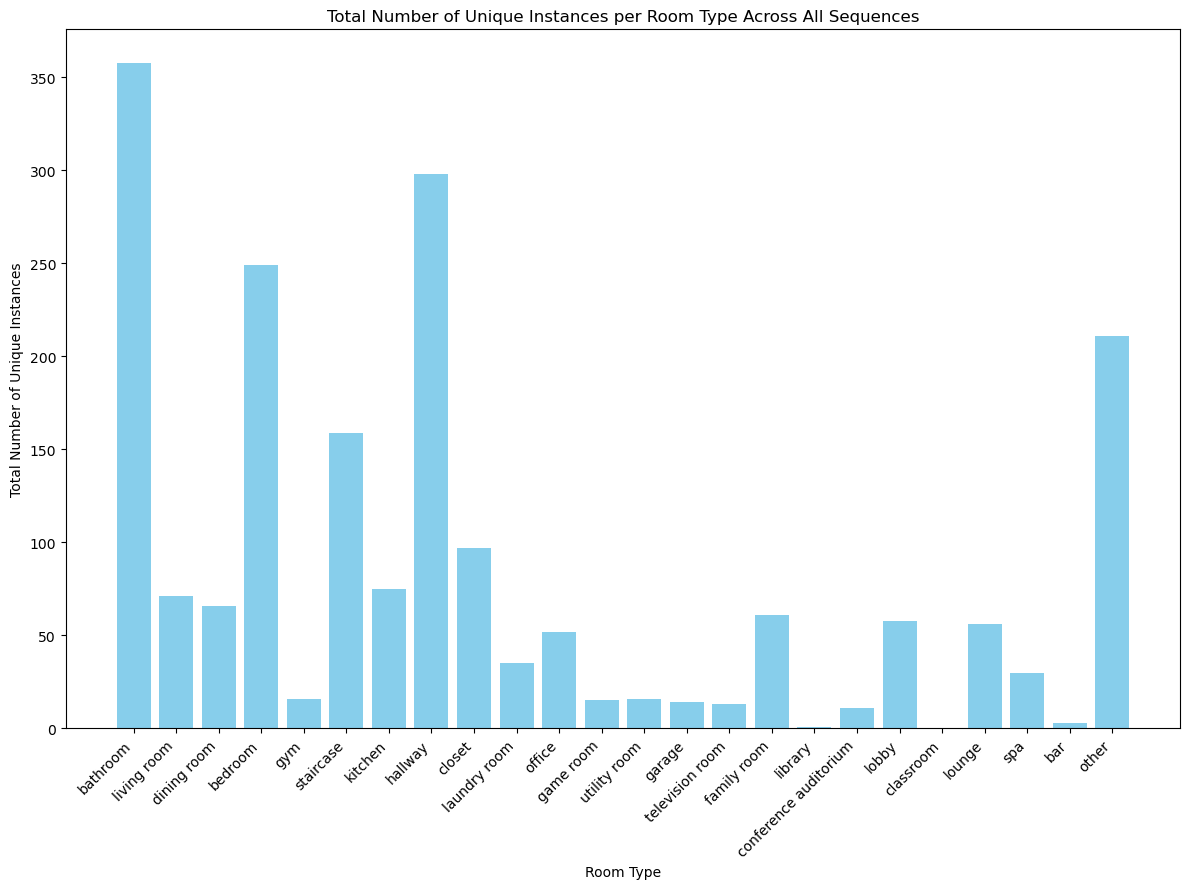

Total number of rooms: 1965


In [5]:
# # Single gt file
# unique_instance_counts = count_unique_instances_per_room_type(gt)
# plot_unique_instances(unique_instance_counts)

# Multiple gt files
updated_gt_dir = "/scratch/kumaraditya_gupta/mp3d_gt_updated"
gt_files = [f for f in os.listdir(updated_gt_dir) if f.endswith('_xyz_rgb_o_r_inst.npy')]

# # List all .npy files in the gt_dir
# gt_files = []
# all_dataset_names = ["RPmz2sHmrrY", "ac26ZMwG7aT", "q9vSo1VnCiC", "sT4fr6TAbpF", "Pm6F8kyY3z2", 
#                      "cV4RVeZvu5T", "e9zR4mvMWw7", "jh4fc5c5qoQ", "kEZ7cmS4wCh", "sKLMLpTHeUy"]

# for file in os.listdir(gt_dir):
#     if file.endswith("_xyz_rgb_o_r_inst.npy") and file.split('_')[0] in all_dataset_names:
#         gt_files.append(file)


aggregated_counts = aggregate_counts_from_all_files(gt_files, updated_gt_dir)
total_rooms = sum(aggregated_counts.values())
plot_aggregated_counts(aggregated_counts)
print(f"Total number of rooms: {total_rooms}")


In [7]:
print(aggregated_counts)

{'bathroom': 358, 'living room': 71, 'dining room': 66, 'bedroom': 249, 'gym': 16, 'staircase': 159, 'kitchen': 75, 'hallway': 298, 'closet': 97, 'laundry room': 35, 'office': 52, 'game room': 15, 'utility room': 16, 'garage': 14, 'television room': 13, 'family room': 61, 'library': 1, 'conference auditorium': 11, 'lobby': 58, 'classroom': 0, 'lounge': 56, 'spa': 30, 'bar': 3, 'other': 211}


In [ ]:
run_1_min_det = {'bathroom': 358, 'living room': 71, 'dining room': 66, 'bedroom': 249, 'gym': 16, 'staircase': 159, 'kitchen': 75, 'hallway': 298, 'closet': 97, 'laundry room': 35, 'office': 52, 'game room': 15, 'utility room': 16, 'garage': 14, 'television room': 13, 'family room': 61, 'library': 1, 'conference auditorium': 11, 'lobby': 58, 'classroom': 0, 'lounge': 56, 'spa': 30, 'bar': 3, 'other': 211}
run_2_min_det = {'bathroom': 358, 'living room': 71, 'dining room': 66, 'bedroom': 249, 'gym': 16, 'staircase': 159, 'kitchen': 75, 'hallway': 298, 'closet': 97, 'laundry room': 35, 'office': 52, 'game room': 15, 'utility room': 16, 'garage': 14, 'television room': 13, 'family room': 61, 'library': 1, 'conference auditorium': 11, 'lobby': 58, 'classroom': 0, 'lounge': 56, 'spa': 30, 'bar': 3, 'other': 211}
